## Pull labels from Labelbox and create patches

In [1]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']

In [2]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()
then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))
print(f'{len(data_rows)} data rows')

2 data rows


In [3]:
CLASSES = {
    'unclassified': 0,
    'agriculture': 1,
    'bare_dark': 2,
    'bare_light': 3,
    'built': 4,
    'burn': 5,
    'cloud': 6,
    'flooded_vegetation': 7,
    'grass_dry': 8,
    'grass_verdant': 9,
    'shrubs': 10,
    'trees': 11,
    'water': 12,   
}

labelbox_dir = "./data/labelbox"
images_dir = f'{labelbox_dir}/images'
labels_dir = f'{labelbox_dir}/labels'
temp_dir = f'{labelbox_dir}/temp'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

In [6]:
%reload_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
from patchify import patchify
from shapely.geometry import box
import rasterio

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.download as download
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


RES_M = 10 # meters
INPUT_SIZE = 512

if not os.path.exists(labelbox_dir):
    os.makedirs(labelbox_dir)
    
# loop through each image (i.e. data row)
for row in data_rows:
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    composite_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'composite_float32_cog')
    job_name = composite_cog_url.split('/')[4]
    rgb_cog_src = rasterio.open(rgb_cog_url)
    
    print(rgb_cog_url)
    
    # get details about the image
    drow = client.get_data_row(row_id)
    bounds = drow.media_attributes['bounds']
    bbox = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]
    bbox_poly_ll = box(*bbox)
    print('job bounds:', bbox)
   
    # create an empty labels array with zeros for unclassified
    res = RES_M / (111.32 * 1000)
    ncols = int((bounds[1][0] - bounds[0][0]) / res + 0.5)
    nrows = int((bounds[1][1] - bounds[0][1]) / res + 0.5)
    labels_data = np.zeros((nrows, ncols)).astype(np.uint8)
    
    patch_row_indexes = np.arange(0, nrows, INPUT_SIZE)
    patch_col_indexes = np.arange(0, ncols, INPUT_SIZE)    
    
    print('labels.shape:', labels_data.shape)
    print(f'{len(labels)} labeled boxes')
    
    # loop through each labeled rectangle in the image
    for i, label in enumerate(labels):
        class_title = label['title']
        class_value = label['value']
        label_id = label['featureId']
        coords = label['geometry']['coordinates'][0][:-1]
        class_idx = CLASSES[class_value]
        
        # get the bbox of the labeled reactangle
        lons = [coord[0] for coord in coords]
        lats = [coord[1] for coord in coords]
        x_min, y_min = min(lons), min(lats)
        x_max, y_max = max(lons), max(lats)
        bbox = [x_min, y_min, x_max, y_max]
                        
        # get the row/col offset of the rectangle in the image
        row_min, col_min = rgb_cog_src.index(x_min, y_max)
        row_max, col_max = rgb_cog_src.index(x_max, y_min)
            
        # if label is cut off by patch then skip
        is_row_overlap = np.logical_and(patch_row_indexes > row_min, patch_row_indexes < row_max).sum() > 0
        is_col_overlap = np.logical_and(patch_col_indexes > col_min, patch_col_indexes < col_max).sum() > 0
        if is_row_overlap or is_col_overlap:
            continue
            
        labels_data[row_min:row_max, col_min:col_max] = class_idx
 
    rgb_cog_src.close()

    # create patches
        
    with rasterio.open(f'./data/{job_name}/composite.tif') as composite_src:
        composite_transform = composite_src.transform
        composite_data = composite_src.read(masked=True)
                
    composite_data = composite_data.transpose((1, 2, 0))
                 
    image_patches = patchify(composite_data, (INPUT_SIZE, INPUT_SIZE, composite_data.shape[2]), step=INPUT_SIZE)
    label_patches = patchify(labels_data, (INPUT_SIZE, INPUT_SIZE), step=INPUT_SIZE)
    
    assert image_patches.shape[0] == label_patches.shape[0]
    assert image_patches.shape[1] == label_patches.shape[1]
    
    for irow in range(label_patches.shape[0]):
        for icol in range(label_patches.shape[1]):
            label_data = label_patches[irow, icol, :, :]
            nonzero_count = np.count_nonzero(label_data)
            
            # ignore patches with little labels
            if nonzero_count > 100:
                
                # don't know what nodata should be (0 or very negative)
                # might need to skip really masked images and fill in slightly masked ones...
                
                image_data = image_patches[irow, icol, 0, :, :, :]
                image_data = np.ma.array(image_data, mask=(image_data==NODATA_FLOAT32))
                                
                image_path = f'{images_dir}/{job_name}_{irow}_{icol}.tif'
                label_path = f'{labels_dir}/{job_name}_{irow}_{icol}.tif'
                
                x_min, y_min, rasterio.transform.xy(composite_transform, INPUT_SIZE*(irow+1), INPUT_SIZE*icol)
                x_max, y_max, rasterio.transform.xy(composite_transform, INPUT_SIZE*irow, INPUT_SIZE*(icol+1))             
                bbox = [x_min, y_min, x_max, y_max]

                imagery.write_array_to_tif(image_data, image_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                imagery.write_array_to_tif(label_data, label_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)
                    

https://data.smartcarte.earth/training/20210101_20210301_south/20210101_20210301_south_rgb_byte_cog.tif
job bounds: (29.296298, -1.5822666762486526, 29.769258833632772, -1.19752)
labels.shape: (4283, 5265)
223 labeled boxes
https://data.smartcarte.earth/training/20200701_20200901_south/20200701_20200901_south_rgb_byte_cog.tif
job bounds: (29.296298, -1.5822666762486526, 29.769258833632772, -1.19752)
labels.shape: (4283, 5265)
35 labeled boxes


In [8]:
import os
import shutil

if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    

(4, 512, 512)
(512, 512)


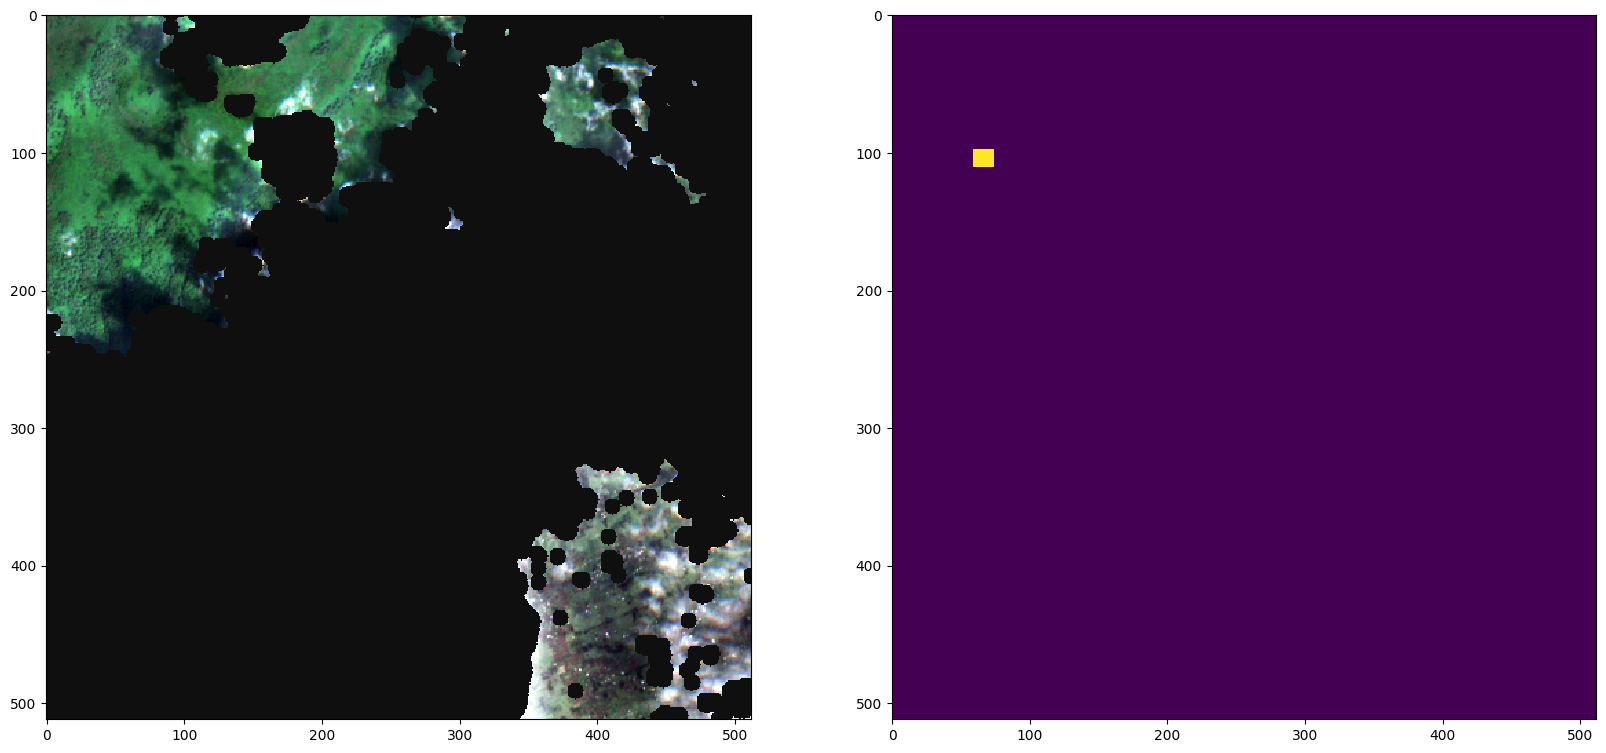

In [13]:
%reload_ext autoreload
%autoreload 2

import common.utilities.visualization as visualization


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

job = '20210101_20210301_south_5_4'

with rasterio.open(f"{labelbox_dir}/images/{job}.tif") as f:
    data = f.read(masked=True)
    #ax1.imshow(data[3, :, :])
    visualization.plot_bands(data, bands=[2, 1, 0], ax=ax1, transpose=True)
    
with rasterio.open(f"{labelbox_dir}/labels/{job}.tif") as f:
    data = f.read(1)
    visualization.plot_bands(data, bands=1, ax=ax2, cmap="viridis")
    

In [29]:
%%bash

#gdalinfo ./data/testingLabelbox/temp/20200701_20200901_south_labels.tif
#gdalinfo ./data/testingLabelbox/temp/test_image.tif
gdalinfo -stats ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif

Driver: GTiff/GeoTIFF
Files: ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif
Size is 512, 512
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (29.419843151244791,-1.282568144157036)
Pixel Size = (0.000005321225825,-0.000007078426298)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  29.4198432,  -1.2825681) ( 29d25'11.44"E,  1d16'57.25"S)
Lower Left  (  29.4198432,  -1.2861923) ( 29d25'11.44"E,  1d

## Split folders into training / validation

In [14]:
import shutil
import splitfolders

training_dir = "./data/trainingData"

if os.path.exists(training_dir):
    shutil.rmtree(training_dir)

splitfolders.ratio(labelbox_dir, output=training_dir, seed=314, ratio=(.8, .1, .1), group_prefix=None)

print('done')

Copying files: 119 files [00:53,  2.22 files/s]

done


[-- 0.012400000356137753 12490124.0 --]
